In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/training_videos_non_masked.zip -d /content/
dataset_path = '/content/training_videos_non_masked'


Streaming output truncated to the last 5000 lines.
  inflating: /content/training_videos_non_masked/deaf/video273.mp4/100.jpg  
  inflating: /content/training_videos_non_masked/deaf/video273.mp4/105.jpg  
  inflating: /content/training_videos_non_masked/deaf/video273.mp4/110.jpg  
  inflating: /content/training_videos_non_masked/deaf/video273.mp4/115.jpg  
  inflating: /content/training_videos_non_masked/deaf/video273.mp4/120.jpg  
  inflating: /content/training_videos_non_masked/deaf/video273.mp4/125.jpg  
  inflating: /content/training_videos_non_masked/deaf/video273.mp4/130.jpg  
  inflating: /content/training_videos_non_masked/deaf/video273.mp4/135.jpg  
  inflating: /content/training_videos_non_masked/deaf/video273.mp4/140.jpg  
  inflating: /content/training_videos_non_masked/deaf/video273.mp4/145.jpg  
  inflating: /content/training_videos_non_masked/deaf/video273.mp4/150.jpg  
   creating: /content/training_videos_non_masked/deaf/video290.mp4/
  inflating: /content/training_vid

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from torch.utils.data import random_split


Image batch shape: torch.Size([25, 1, 224, 400])
Labels: tensor([4, 0, 4, 4, 3, 9, 3, 1, 1, 6, 5, 0, 0, 5, 4, 2, 5, 7, 1, 7, 6, 1, 4, 3,
        0])


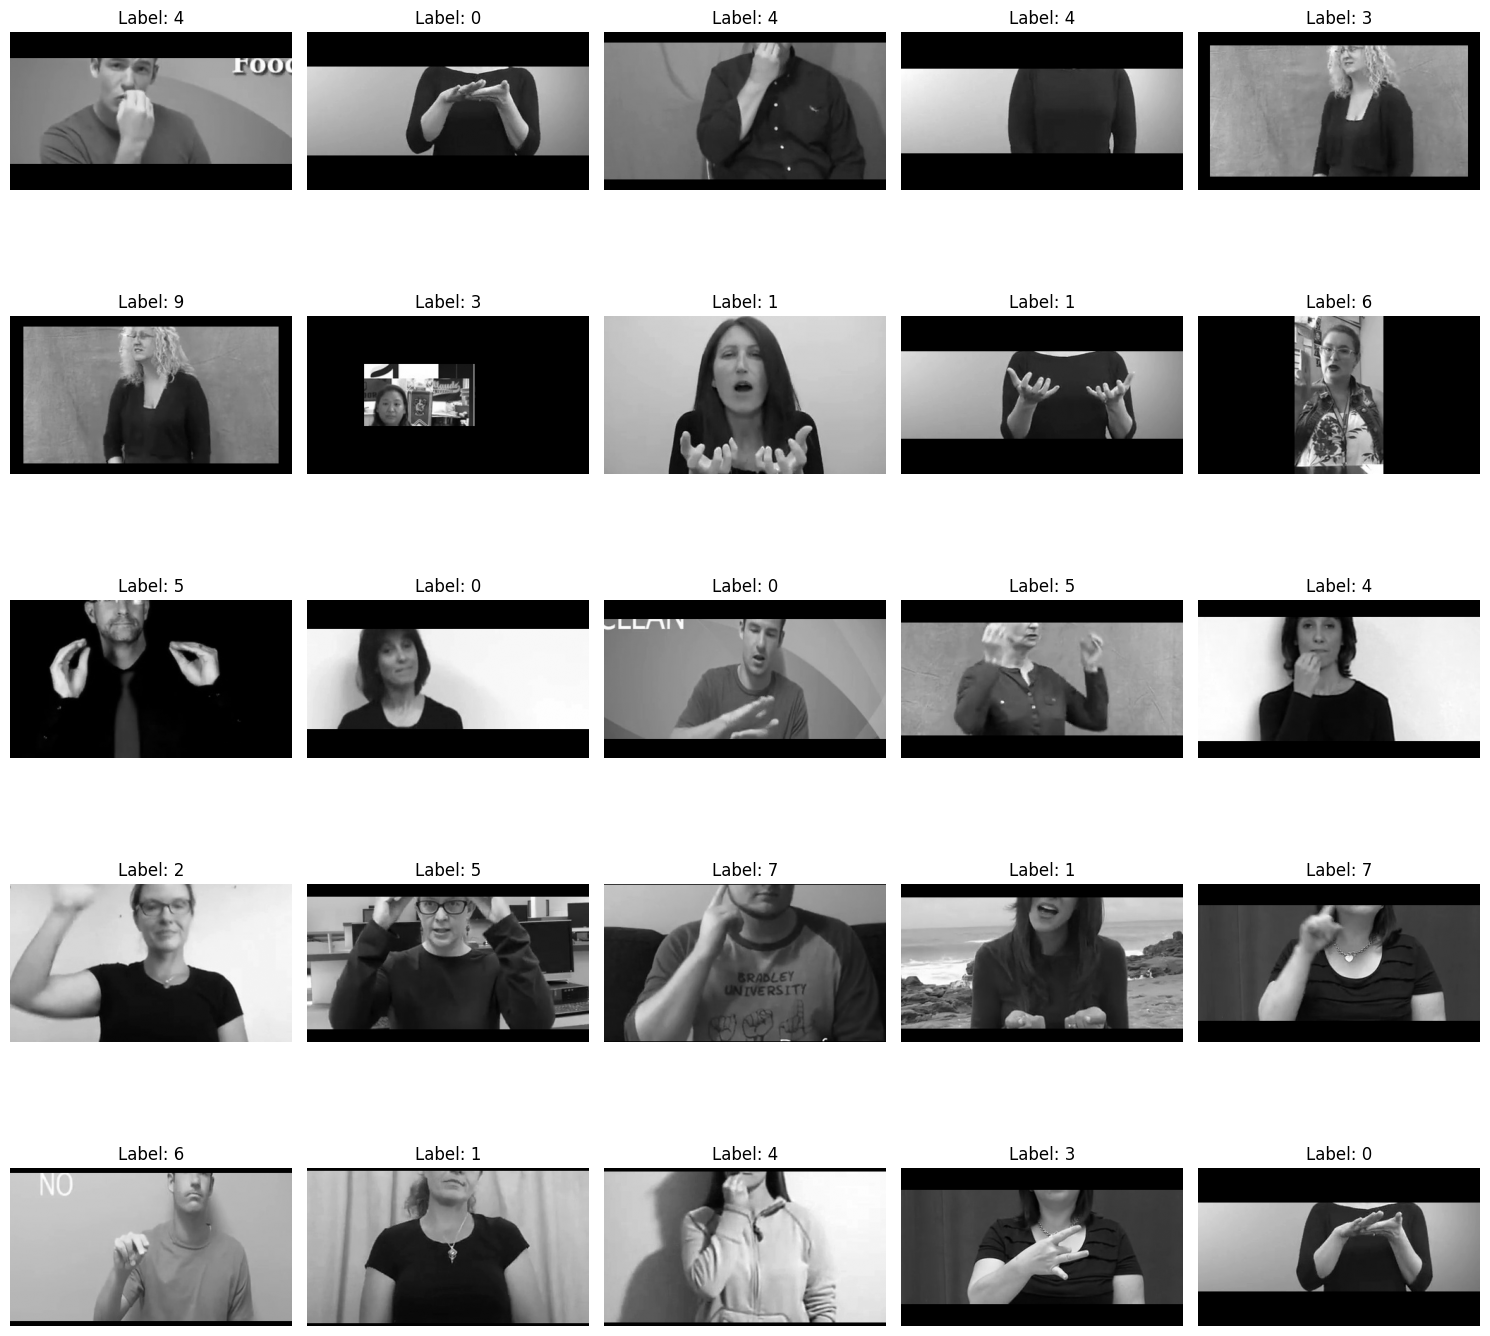

In [ ]:
ALLOWED_EXTENSIONS = {'.jpg', '.jpeg', '.png'}

def _is_image_file(filename):
    return any(filename.lower().endswith(ext) for ext in ALLOWED_EXTENSIONS)

# Dataset class that only loads the middle frame
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.video_dirs = []
        self.labels = []
        self.label2idx = {}

        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                if class_name not in self.label2idx:
                    self.label2idx[class_name] = len(self.label2idx)
                for video_id in os.listdir(class_path):
                    video_path = os.path.join(class_path, video_id)
                    if os.path.isdir(video_path):
                        frame_files = [f for f in os.listdir(video_path) if _is_image_file(f)]
                        if len(frame_files) == 0:
                            continue
                        self.video_dirs.append(video_path)
                        self.labels.append(self.label2idx[class_name])

    def __len__(self):
        return len(self.video_dirs)

    def __getitem__(self, idx):
        video_path = self.video_dirs[idx]
        label = self.labels[idx]
        frame_files = sorted([f for f in os.listdir(video_path) if _is_image_file(f)])
        if not frame_files:
            raise ValueError(f"No image files found in {video_path}")

        middle_idx = len(frame_files) // 2
        frame_path = os.path.join(video_path, frame_files[middle_idx])
        img = Image.open(frame_path).convert('L')
        if self.transform:
            img = self.transform(img)
        return img, label  # img shape: (C, H, W)

# Define image transforms (resize, crop, tensor)
transform = transforms.Compose([
    transforms.CenterCrop((224, 400)),
    transforms.ToTensor()
])

# Dataset and dataloader
root_folder = 'training_videos_non_masked'
dataset = VideoDataset(root_dir=root_folder, transform=transform)


train_size = int(0.8 * len(dataset))  # 80% train
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


if len(dataset) == 0:
    raise ValueError("Dataset is empty. Check folder structure and contents.")


train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=25, shuffle=False)

# Visualization of first batch (middle frames)
for images, labels in train_loader:
    print("Image batch shape:", images.shape)  # (batch_size, C, H, W)
    print("Labels:", labels)
    to_pil = ToPILImage()

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))  # 25 images (5x5)
    axes = axes.flatten()

    for i in range(min(len(images), 25)):
        pil_img = to_pil(images[i])
        axes[i].imshow(pil_img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Label: {labels[i].item()}')

    # Hide any unused subplots
    for j in range(len(images), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    break  # only one batch


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Grayscale: 1 input channel
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 100, 256)  # Adjust this based on image size
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> (B, 16, 112, 200)
        x = self.pool(F.relu(self.conv2(x)))  # -> (B, 32, 56, 100)
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = SimpleCNN(num_classes=len(dataset.label2idx)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.2f}%")


cuda
Epoch 1: Loss = 59.5806, Accuracy = 9.00%
Epoch 2: Loss = 22.8434, Accuracy = 12.32%
Epoch 3: Loss = 20.0418, Accuracy = 25.59%
Epoch 4: Loss = 18.2208, Accuracy = 31.28%
Epoch 5: Loss = 15.9088, Accuracy = 42.18%
Epoch 6: Loss = 11.7277, Accuracy = 63.51%
Epoch 7: Loss = 8.7358, Accuracy = 76.30%
Epoch 8: Loss = 5.5837, Accuracy = 85.78%
Epoch 9: Loss = 3.0965, Accuracy = 92.89%
Epoch 10: Loss = 1.4116, Accuracy = 98.58%
Epoch 11: Loss = 0.9843, Accuracy = 98.10%
Epoch 12: Loss = 0.7770, Accuracy = 98.58%
Epoch 13: Loss = 0.4254, Accuracy = 99.53%
Epoch 14: Loss = 0.1886, Accuracy = 99.53%
Epoch 15: Loss = 0.1493, Accuracy = 99.53%
Epoch 16: Loss = 0.0492, Accuracy = 100.00%
Epoch 17: Loss = 0.0323, Accuracy = 100.00%
Epoch 18: Loss = 0.0269, Accuracy = 100.00%
Epoch 19: Loss = 0.0185, Accuracy = 100.00%
Epoch 20: Loss = 0.0139, Accuracy = 100.00%


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

acc = 100 * correct / total
print(f"Test Accuracy: {acc:.2f}%")

Test Accuracy: 32.08%
